In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Reading the data
data = pd.read_csv('final.csv')
data['baby2'] = data['baby2'].astype('category')

In [3]:
data.head()

,X,country,population,lifeexp,childmort,income,gdpcapita,chdperwoman,healthspend,co2,water,popdensity,murder,continent,baby2
0,1,Afghanistan,29200000.0,60.5,88.0,1960,543,5.82,37.7,0.29,73.5,44.7,4940.0,Asia,0
1,2,Albania,2950000.0,78.1,13.3,10800,4090,1.65,241.0,1.56,92.9,108.0,68.4,Europe,1
2,3,Algeria,36000000.0,74.5,27.4,11000,4480,2.89,178.0,3.28,95.0,15.1,447.0,Africa,0
3,5,Angola,23400000.0,60.2,120.0,7690,3590,6.16,123.0,1.24,67.5,18.7,978.0,Africa,0
4,7,Argentina,40900000.0,75.9,14.4,23500,10400,2.37,742.0,4.57,99.3,14.9,2390.0,Americas,0


Exploratory Data Analysis 

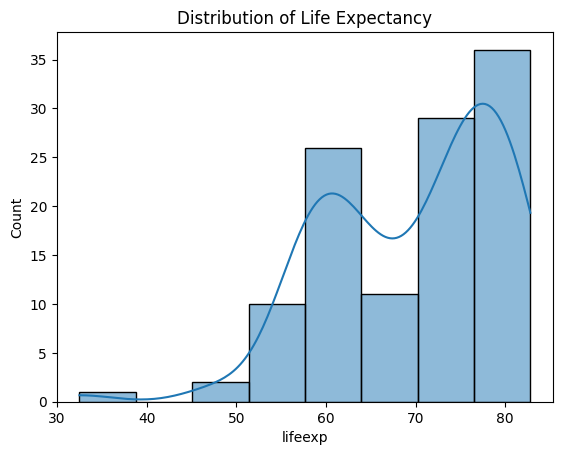

In [4]:
# Plotting histogram of life expectancy
sns.histplot(data['lifeexp'], kde=True)
plt.title('Distribution of Life Expectancy')
plt.show()

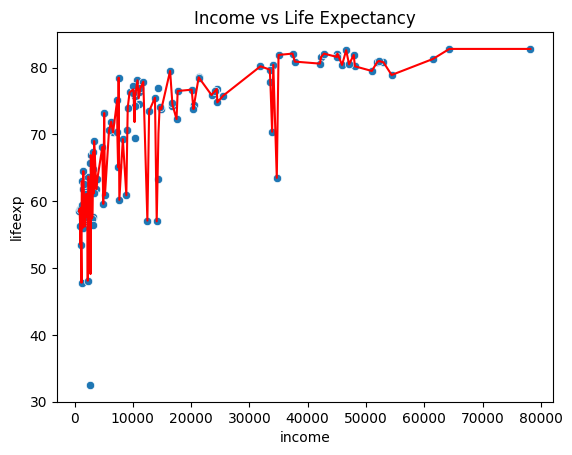

In [5]:
# Plotting relationship between avg income and life expectancy for each country 
sns.scatterplot(data=data, x='income', y='lifeexp')
sns.lineplot(data=data, x='income', y='lifeexp', color='red', ci=None)
plt.title('Income vs Life Expectancy')
plt.show()

In [6]:
# Removing outliers that may distort the regression model
data = data[data['lifeexp'] > 40]  # Remove Haiti
data = data[data['popdensity'] < 4000]  # Remove Singapore
data = data[data['murder'] < 40000]  # Remove Brazil

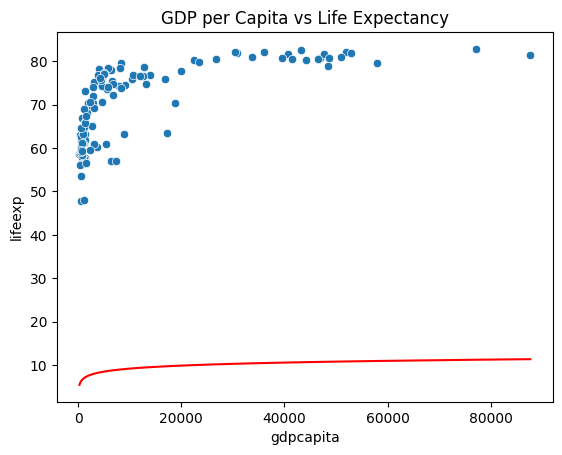

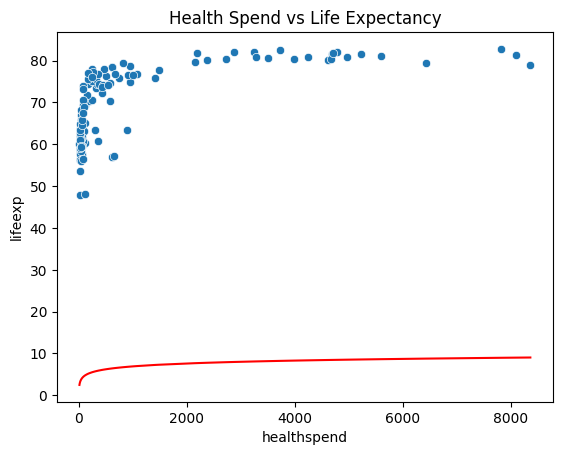

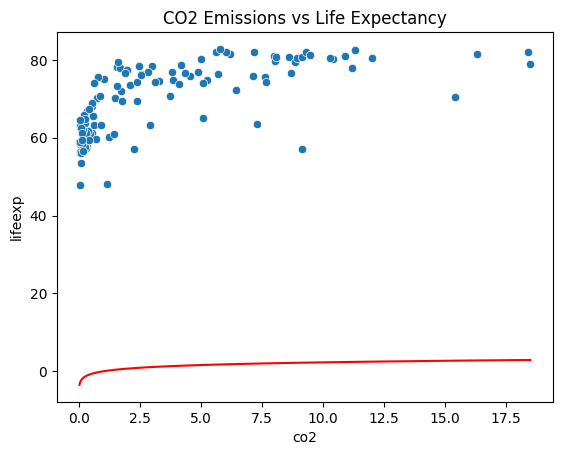

In [7]:
# Plotting relationships with transformations
sns.scatterplot(data=data, x='gdpcapita', y='lifeexp')
sns.lineplot(data=data, x='gdpcapita', y=np.log(data['gdpcapita']), color='red', ci=None)
plt.title('GDP per Capita vs Life Expectancy')
plt.show()

sns.scatterplot(data=data, x='healthspend', y='lifeexp')
sns.lineplot(data=data, x='healthspend', y=np.log(data['healthspend']), color='red', ci=None)
plt.title('Health Spend vs Life Expectancy')
plt.show()

sns.scatterplot(data=data, x='co2', y='lifeexp')
sns.lineplot(data=data, x='co2', y=np.log(data['co2']), color='red', ci=None)
plt.title('CO2 Emissions vs Life Expectancy')
plt.show()

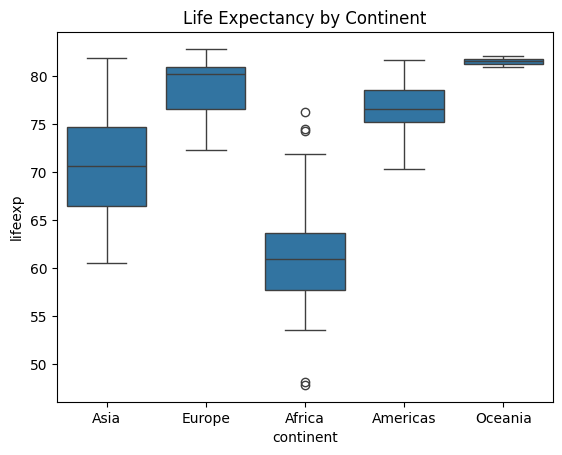

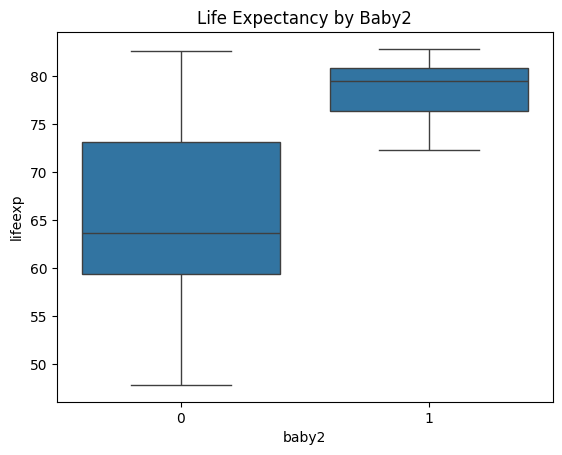

In [8]:
# Boxplots for categorical variables
sns.boxplot(data=data, x='continent', y='lifeexp')
plt.title('Life Expectancy by Continent')
plt.show()

sns.boxplot(data=data, x='baby2', y='lifeexp')
plt.title('Life Expectancy by Baby2')
plt.show()

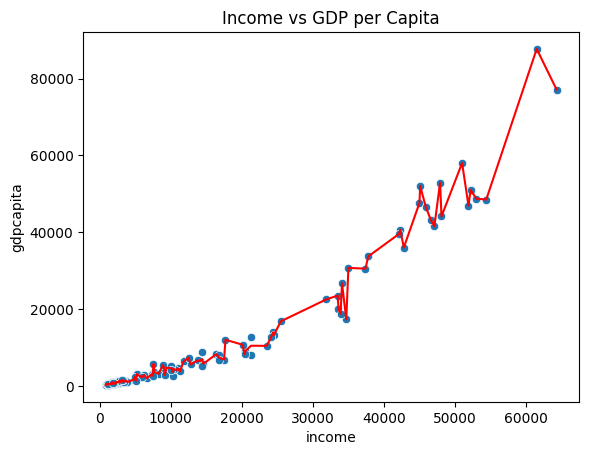

Correlation between income and gdpcapita: 0.9564100573090815


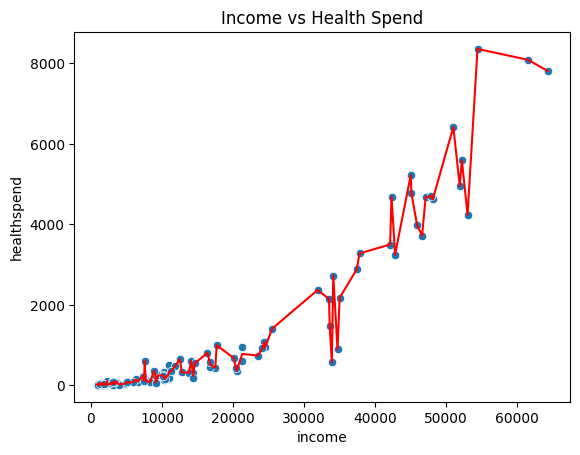

Correlation between income and healthspend: 0.9240826657127234


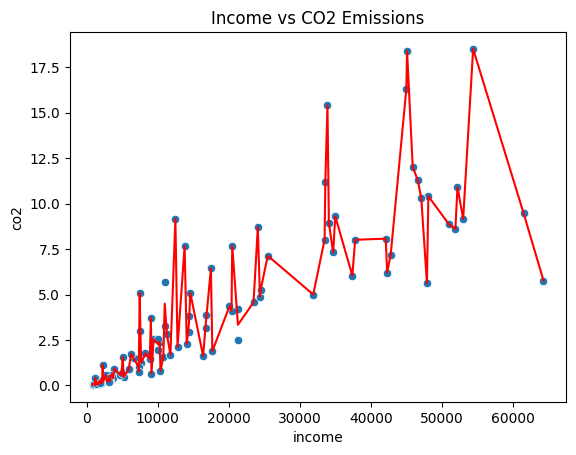

Correlation between income and co2: 0.8531396504369275


In [9]:
# Checking for multicollinearity
sns.scatterplot(data=data, x='income', y='gdpcapita')
sns.lineplot(data=data, x='income', y='gdpcapita', color='red', ci=None)
plt.title('Income vs GDP per Capita')
plt.show()
print("Correlation between income and gdpcapita:", data['income'].corr(data['gdpcapita']))

sns.scatterplot(data=data, x='income', y='healthspend')
sns.lineplot(data=data, x='income', y='healthspend', color='red', ci=None)
plt.title('Income vs Health Spend')
plt.show()
print("Correlation between income and healthspend:", data['income'].corr(data['healthspend']))

sns.scatterplot(data=data, x='income', y='co2')
sns.lineplot(data=data, x='income', y='co2', color='red', ci=None)
plt.title('Income vs CO2 Emissions')
plt.show()
print("Correlation between income and co2:", data['income'].corr(data['co2']))


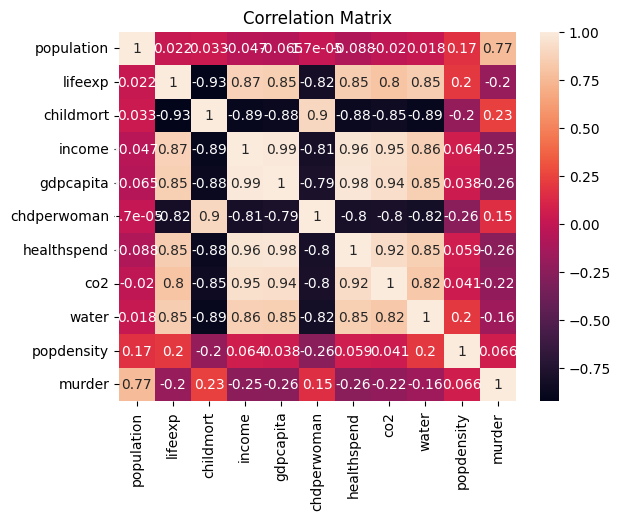

In [10]:
# Selecting variables for the model using a Correlation Matrix
data_new = data.drop(columns=['country', 'X', 'continent', 'baby2'])
correlation_matrix = data_new.corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()


Regression Model

In [11]:
import pandas as pd
import statsmodels.api as sm


# Building the regression model
X = data.drop(columns=['lifeexp', 'country', 'X'])
X = pd.get_dummies(X, drop_first=True)  # Encoding categorical variables
y = data['lifeexp']

X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)


for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

model = sm.OLS(y, sm.add_constant(X)).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                lifeexp   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     58.76
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           1.61e-41
Time:                        12:13:11   Log-Likelihood:                -276.93
No. Observations:                 112   AIC:                             585.9
Df Residuals:                      96   BIC:                             629.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 70.6650      6

In [12]:
# Selecting a Model 

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out=0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Add  {best_feature} with p-value {best_pval}')

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Remove  {worst_feature} with p-value {worst_pval}')
        if not changed:
            break
    return included

result = stepwise_selection(X, y)
print('Resulting features:')
print(result)



Add  childmort with p-value 4.6798592078826807e-42
Add  income with p-value 5.7560202599242854e-08
Add  continent_Americas with p-value 0.0018355846549694154
Resulting features:
['childmort', 'income', 'continent_Americas']


                            OLS Regression Results                            
Dep. Variable:                lifeexp   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     242.8
Date:                Thu, 08 Aug 2024   Prob (F-statistic):           7.75e-48
Time:                        12:13:11   Log-Likelihood:                -292.26
No. Observations:                 112   AIC:                             592.5
Df Residuals:                     108   BIC:                             603.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 73.1142      0

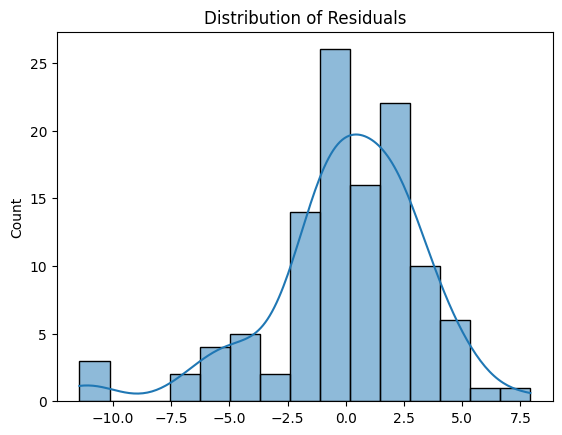

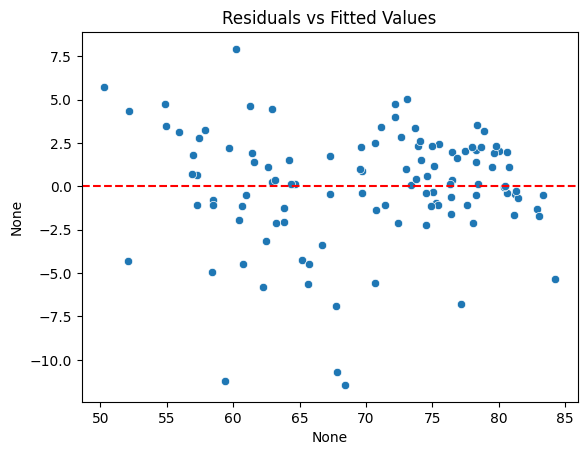

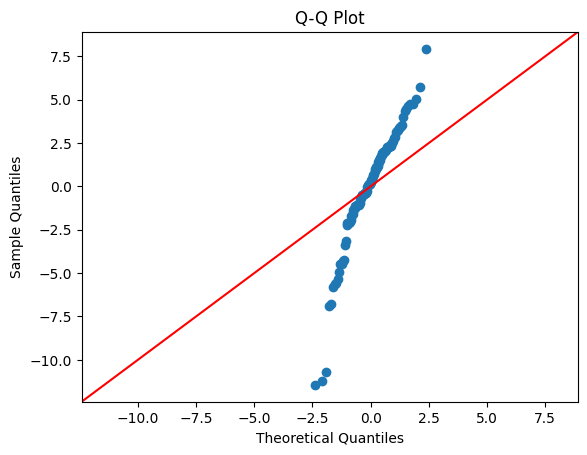

Mean of residuals: 1.660512996945077e-12
Variance of residuals: 10.816298072573986
Durbin-Watson statistic: 2.0574783369428533
              feature       VIF
0               const  8.532075
1           childmort  1.992436
2              income  1.860378
3  continent_Americas  1.123320


In [13]:
X_final = sm.add_constant(X[result])
model_final = sm.OLS(y, X_final).fit()
print(model_final.summary())


residuals = model_final.resid

# Plotting residuals
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

sns.scatterplot(x=model_final.fittedvalues, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.show()

sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot')
plt.show()

# Checking for assumptions
print("Mean of residuals:", np.mean(residuals))
print("Variance of residuals:", np.var(residuals))
print("Durbin-Watson statistic:", sm.stats.durbin_watson(residuals))

# Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["feature"] = X_final.columns
vif_data["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(X_final.shape[1])]
print(vif_data)